# spectrogram variational auto encoder

- auto encoder를 학습하는 모델.
- healthy 데이터를 fold에 맞게 학습해본다.

05.10

- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display 

p = os.path.abspath('D:/project/voice_pathology_ai/model') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
import torchaudio
import torchaudio.transforms as T

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# healthy 데이터 불러오기

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

In [4]:
import pickle
#load
fold_list=[]
for fold in range(5):
    with open("D:/project/voice_pathology_ai/model/varauto/spectro/alldata/fold{}/healthy/healthy-stft.pickle".format(fold+1),"rb") as fr:
        healthy_dict = pickle.load(fr)
        fold_list.append(healthy_dict)

In [5]:
len(fold_list)

5

In [6]:
X_train_list=[]
for i in range(5):
    X_train_list.append( list(fold_list[i].keys()) )

In [7]:
print('1폴드당 데이터 수 : ',len(X_train_list[0]))

1폴드당 데이터 수 :  406


학습 데이터, 전부 이용해서, 200개의 sample 추출.

# normalizer 구성.

healthy data
- mean : -25.12305862766925
- std : 17.943412194886722

# 데이터 정의


0503 여기부터 수정.

In [8]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler



sr=16000
win_length =  np.int64(sr/40) # 
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,data_num,transform=None,):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.transform = transform
        
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        """
        stft = fold_list[self.data_num][self.path_list[idx]]
        
        #padding
        length=300
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        stft = pad2d(stft, length)
        stft=stft[:128,:]# 224 x 300 으로 사이즈 조절
        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)
        
        if self.transform:
            log_spectrogram = self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            log_spectrogram = log_spectrogram.squeeze(dim=0)
            
        else:
            #print("else")
            ##################안쓰는 곳
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return log_spectrogram,
    
    

# 데이터 로더

In [9]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 100번 반복

In [10]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인
#transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               transform=transforms.Compose([transforms.ToTensor(),
                                                                             transforms.Normalize((-25.123058,),(17.943412,))]),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                               data_num=0,
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.




# 데이터 확인

X_train :  torch.Size([32, 128, 300]) type: torch.FloatTensor


Text(0.5, 1.0, 'Spectrogram (dB)')

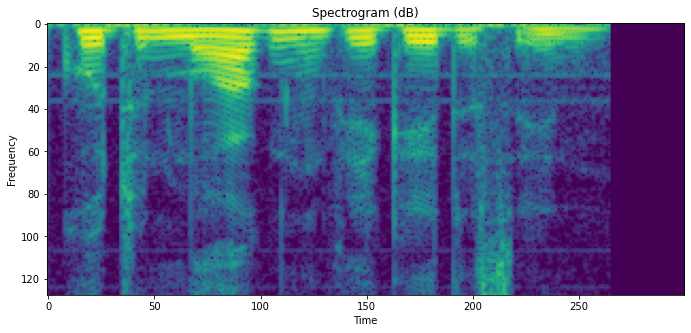

In [11]:
# 4. 데이터 확인하기
for (X_train,) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    break

plt.figure(figsize=(15,5))
plt.imshow(X_train[0].view(128,300,1).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

In [12]:
for i in range(32):
    print(X_train[i].min(),X_train[i].max())

tensor(-1.3943) tensor(3.0642)
tensor(-1.8905) tensor(2.5680)
tensor(-1.6381) tensor(2.8204)
tensor(-1.0785) tensor(3.3799)
tensor(-1.4279) tensor(3.0306)
tensor(-1.2347) tensor(3.2238)
tensor(-1.0311) tensor(3.4273)
tensor(-1.2108) tensor(3.2477)
tensor(-1.4610) tensor(2.9975)
tensor(-1.4323) tensor(3.0262)
tensor(-1.5775) tensor(2.8810)
tensor(-1.3192) tensor(3.1393)
tensor(-1.5890) tensor(2.8694)
tensor(-1.1584) tensor(3.3001)
tensor(-1.4820) tensor(2.9764)
tensor(-1.6926) tensor(2.7659)
tensor(-1.5448) tensor(2.9137)
tensor(-1.2404) tensor(3.2180)
tensor(-1.3721) tensor(3.0863)
tensor(-1.2213) tensor(3.2372)
tensor(-1.1641) tensor(3.2943)
tensor(-1.2864) tensor(3.1720)
tensor(-1.0876) tensor(3.3709)
tensor(-1.2708) tensor(3.1877)
tensor(-1.2910) tensor(3.1675)
tensor(-1.6207) tensor(2.8377)
tensor(-1.2928) tensor(3.1656)
tensor(-1.3772) tensor(3.0813)
tensor(-1.3859) tensor(3.0725)
tensor(-1.1186) tensor(3.3399)
tensor(-0.9565) tensor(3.5020)
tensor(-1.2723) tensor(3.1861)


# variational auto encoder

https://towardsdatascience.com/building-a-convolutional-vae-in-pytorch-a0f54c947f71

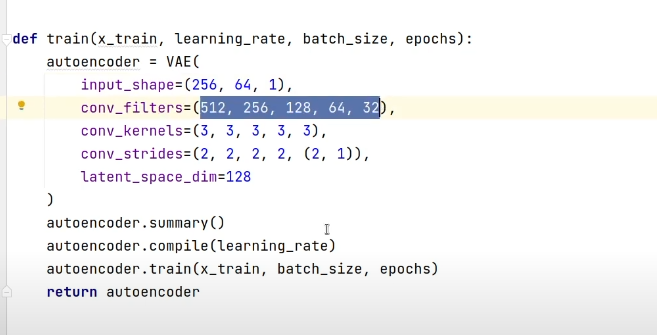

In [13]:

input_data=torch.ones((32,128,300))

conv1=nn.Conv1d(in_channels=128,out_channels=512,kernel_size=3,stride=2)
conv2=nn.Conv1d(in_channels=512,out_channels=256,kernel_size=3,stride=2)
conv3=nn.Conv1d(in_channels=256,out_channels=128,kernel_size=3,stride=2)
conv4=nn.Conv1d(in_channels=128,out_channels=64,kernel_size=3,stride=2)
conv5=nn.Conv1d(in_channels=64,out_channels=32,kernel_size=3,stride=2)

x= conv1(input_data)
print(x.size())
x= conv2(x)
print(x.size())
x= conv3(x)
print(x.size())
x= conv4(x)
print(x.size())
x= conv5(x)
x.size()



torch.Size([32, 512, 149])
torch.Size([32, 256, 74])
torch.Size([32, 128, 36])
torch.Size([32, 64, 17])


torch.Size([32, 32, 8])

In [14]:
input_data=torch.ones((32,32,8))

decoder_conv1=nn.ConvTranspose1d(in_channels=32,out_channels=64,kernel_size=3,stride=2)
decoder_conv2=nn.ConvTranspose1d(in_channels=64,out_channels=128,kernel_size=4,stride=2)
decoder_conv3=nn.ConvTranspose1d(in_channels=128,out_channels=256,kernel_size=4,stride=2)
decoder_conv4=nn.ConvTranspose1d(in_channels=256,out_channels=512,kernel_size=3,stride=2)
decoder_conv5=nn.ConvTranspose1d(in_channels=512,out_channels=128,kernel_size=4,stride=2)

x= decoder_conv1(input_data)
print(x.size())
x= decoder_conv2(x)
print(x.size())
x= decoder_conv3(x)
print(x.size())
x= decoder_conv4(x)
print(x.size())
x= decoder_conv5(x)
x.size()



torch.Size([32, 64, 17])
torch.Size([32, 128, 36])
torch.Size([32, 256, 74])
torch.Size([32, 512, 149])


torch.Size([32, 128, 300])

모델의 문제점

train set이 -1~ +4 정도 되는데, activation function에 따라, -1~1 사이 값 정도만 출력되거나 범위가 정해진다.



In [15]:
# 모델 

class VAE(nn.Module):
    def __init__(self, imgChannels=128,encoderDim=32*8,zDim=128):
        super(VAE, self).__init__()
        
        self.encoderDim = encoderDim
        self.imgChannels =imgChannels
        self.zDim = zDim
        
        #self.batchnorm_enc = nn.BatchNorm2d(affine=False)
        #self.batchnorm_dec = nn.BatchNorm2d(affine=False)
        
        
        
        # encoder part
        self.encoder_conv1=nn.Conv1d(imgChannels,512,3,2)
        self.encoder_conv2=nn.Conv1d(512,256,3,2)
        self.encoder_conv3=nn.Conv1d(256,128,3,2)
        self.encoder_conv4=nn.Conv1d(128,64,3,2)
        self.encoder_conv5=nn.Conv1d(64,32,3,2)
        
        self.encFC1 = nn.Linear(encoderDim,zDim)
        self.encFC2 = nn.Linear(encoderDim,zDim)
        
        # decoder part
        self.decFC1 = nn.Linear(zDim,encoderDim)
        
        self.decoder_conv1=nn.ConvTranspose1d(in_channels=32,out_channels=64,kernel_size=3,stride=2)
        self.decoder_conv2=nn.ConvTranspose1d(in_channels=64,out_channels=128,kernel_size=4,stride=2)
        self.decoder_conv3=nn.ConvTranspose1d(in_channels=128,out_channels=256,kernel_size=4,stride=2)
        self.decoder_conv4=nn.ConvTranspose1d(in_channels=256,out_channels=512,kernel_size=3,stride=2)
        self.decoder_conv5=nn.ConvTranspose1d(in_channels=512,out_channels=128,kernel_size=4,stride=2)
        
        
        #encoder batchnorm
        self.enc_batch1 = nn.BatchNorm1d(512)
        self.enc_batch2 = nn.BatchNorm1d(256)
        self.enc_batch3 = nn.BatchNorm1d(128)
        self.enc_batch4 = nn.BatchNorm1d(64)
        self.enc_batch5 = nn.BatchNorm1d(32)
        
        
        #decoder batchnorm
        self.dec_batch1 = nn.BatchNorm1d(64)
        self.dec_batch2 = nn.BatchNorm1d(128)
        self.dec_batch3 = nn.BatchNorm1d(256)
        self.dec_batch4 = nn.BatchNorm1d(512)
        self.dec_batch5 = nn.BatchNorm1d(128)
        
    def encoder(self, x):
        h = F.relu(self.encoder_conv1(x))
        h = self.enc_batch1(h)
        
        h = F.relu(self.encoder_conv2(h))
        h = self.enc_batch2(h)
        
        h = F.relu(self.encoder_conv3(h))
        h = self.enc_batch3(h)
        
        h = F.relu(self.encoder_conv4(h))
        h = self.enc_batch4(h)
        
        h = F.relu(self.encoder_conv5(h))
        h = self.enc_batch5(h)
        
        h = h.view(-1,self.encoderDim)
        
        mu = self.encFC1(h)
        logVar = self.encFC2(h)
        
        return mu, logVar
    
    def sampling(self, mu, log_var):
        #reparameterize
        std = torch.exp(0.5*log_var) # e^(0.5*log_var)
        eps = torch.randn_like(std) # std사이즈와 같은 정규분포 랜덤 z값 생성. 
        
        
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        
        h = self.decFC1(z)
        h = h.view(-1,32,8)
        h = F.relu(self.decoder_conv1(h))
        h = self.dec_batch1(h)
        
        h = F.relu(self.decoder_conv2(h))
        h = self.dec_batch2(h)
        
        h = F.relu(self.decoder_conv3(h))
        h = self.dec_batch3(h)
        
        h = F.relu(self.decoder_conv4(h))
        h = self.dec_batch4(h)
        
        h = self.decoder_conv5(h)
        h = self.dec_batch5(h)
        
        
        h = torch.tanh(h)
        
        return h
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        recon = self.decoder(z)
        # 왜 encoder 결과가 mu와 log_var 인지?
        # 해당 이미지가 mu 에 위치하고, var만큼 퍼져있는 지역에 있다는 의미.
        # z라는 랜덤변수를 추출해서, decoder로.
        
        return recon, mu, log_var

# build model    
def model_initialize():
    vae = VAE()
    vae = vae.cuda()
    return vae

vae=model_initialize()


In [16]:
vae

VAE(
  (encoder_conv1): Conv1d(128, 512, kernel_size=(3,), stride=(2,))
  (encoder_conv2): Conv1d(512, 256, kernel_size=(3,), stride=(2,))
  (encoder_conv3): Conv1d(256, 128, kernel_size=(3,), stride=(2,))
  (encoder_conv4): Conv1d(128, 64, kernel_size=(3,), stride=(2,))
  (encoder_conv5): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
  (encFC1): Linear(in_features=256, out_features=128, bias=True)
  (encFC2): Linear(in_features=256, out_features=128, bias=True)
  (decFC1): Linear(in_features=128, out_features=256, bias=True)
  (decoder_conv1): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(2,))
  (decoder_conv2): ConvTranspose1d(64, 128, kernel_size=(4,), stride=(2,))
  (decoder_conv3): ConvTranspose1d(128, 256, kernel_size=(4,), stride=(2,))
  (decoder_conv4): ConvTranspose1d(256, 512, kernel_size=(3,), stride=(2,))
  (decoder_conv5): ConvTranspose1d(512, 128, kernel_size=(4,), stride=(2,))
  (enc_batch1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [17]:
import torchsummary

torchsummary.summary(vae,input_size=(128,300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 512, 149]         197,120
       BatchNorm1d-2             [-1, 512, 149]           1,024
            Conv1d-3              [-1, 256, 74]         393,472
       BatchNorm1d-4              [-1, 256, 74]             512
            Conv1d-5              [-1, 128, 36]          98,432
       BatchNorm1d-6              [-1, 128, 36]             256
            Conv1d-7               [-1, 64, 17]          24,640
       BatchNorm1d-8               [-1, 64, 17]             128
            Conv1d-9                [-1, 32, 8]           6,176
      BatchNorm1d-10                [-1, 32, 8]              64
           Linear-11                  [-1, 128]          32,896
           Linear-12                  [-1, 128]          32,896
           Linear-13                  [-1, 256]          33,024
  ConvTranspose1d-14               [-1,

In [19]:

#optimizer = torch.optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses

def loss_function(recon_x, x, mu, log_var):
    BCE = F.mse_loss(recon_x, x) #합이 같은지를 비교
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    #print("BCE : ",BCE)
    #print("KLD : ",KLD)
    return BCE + KLD

In [20]:

def train(Epoch,model,train_loader,optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data,) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                Epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(Epoch, train_loss / len(train_loader.dataset)))

In [21]:
#데이터 로더 제작 함수


def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    return train_loader



In [22]:
#10. 학습 및 평가.
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,2):

    check_path = 'D:/project/voice_pathology_ai/model/checkpoint'+str(data_ind)+'_fold_VarAuto_mlp.pt'
    print(check_path)
    train_loader = load_data(data_ind-1)
    
    model=model_initialize()
    optimizer = torch.optim.Adam(model.parameters())
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train(Epoch,model,train_loader,optimizer)
    
    torch.save(model.state_dict(), check_path)
    

D:/project/voice_pathology_ai/model/checkpoint1_fold_VarAuto_mlp.pt
[1 교차검증] 학습 시작
 ----- 
Train Epoch: 1 [0/406 (0%)]	Loss: 70.576111
Train Epoch: 1 [160/406 (38%)]	Loss: 55.566109
Train Epoch: 1 [320/406 (77%)]	Loss: 44.684280
====> Epoch: 1 Average loss: 55.4317
Train Epoch: 2 [0/406 (0%)]	Loss: 39.548046
Train Epoch: 2 [160/406 (38%)]	Loss: 39.831230
Train Epoch: 2 [320/406 (77%)]	Loss: 37.598171
====> Epoch: 2 Average loss: 40.2877
Train Epoch: 3 [0/406 (0%)]	Loss: 38.984379
Train Epoch: 3 [160/406 (38%)]	Loss: 37.919544
Train Epoch: 3 [320/406 (77%)]	Loss: 36.056961
====> Epoch: 3 Average loss: 37.9348
Train Epoch: 4 [0/406 (0%)]	Loss: 37.664730
Train Epoch: 4 [160/406 (38%)]	Loss: 35.406361
Train Epoch: 4 [320/406 (77%)]	Loss: 37.365791
====> Epoch: 4 Average loss: 37.2753
Train Epoch: 5 [0/406 (0%)]	Loss: 36.307552
Train Epoch: 5 [160/406 (38%)]	Loss: 36.382324
Train Epoch: 5 [320/406 (77%)]	Loss: 37.313511
====> Epoch: 5 Average loss: 36.9986
Train Epoch: 6 [0/406 (0%)]	Loss: 

# Model 결과 확인

In [21]:
from torchvision.utils import save_image

torch.Size([2, 128])
torch.Size([2, 128, 300])


Text(0.5, 0, 'Time')

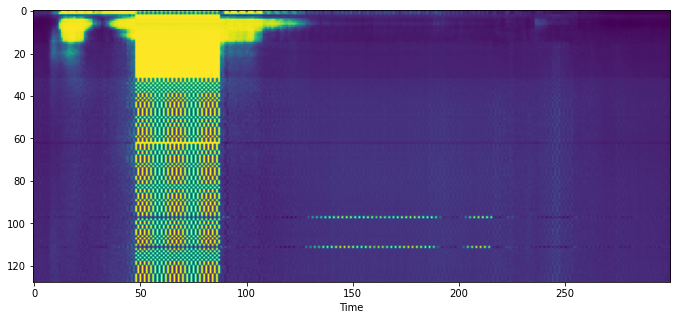

In [22]:
sample = None
with torch.no_grad():
    z = torch.randn(2,128).cuda()
    print(z.size())
    sample = model.decoder(z).cuda()
    print(sample.size())
    
    save_image(sample.view(2, 128, 300), './samples/sample_' + '.png')
plt.figure(figsize=(15,5))
plt.imshow(sample[0].view(128,300).cpu().numpy())
plt.xlabel("Time")

In [23]:
now_data = None
sample = None
with torch.no_grad():
    for batch_idx, (data,) in enumerate(train_loader):
        now_data=data.cuda()
        break
    sample = model(now_data)
    print(sample[0].size())

torch.Size([32, 128, 300])


In [24]:
now_data

tensor([[[-18.2733, -17.5580, -19.2753,  ..., -14.6914, -13.7215,  -7.0027],
         [-19.5520, -16.9389, -15.6437,  ..., -12.9041, -13.4233, -11.4686],
         [-23.5422, -22.2796, -38.8040,  ..., -22.1093, -20.3179, -21.8871],
         ...,
         [-53.5425, -53.5425, -53.5425,  ..., -44.4563, -49.1342, -49.3595],
         [-53.5425, -53.5425, -52.7844,  ..., -43.8043, -40.5479, -46.3194],
         [-53.5425, -53.5425, -53.5425,  ..., -41.2776, -39.8475, -43.5227]],

        [[ -5.4197,  -0.5163,  -1.8230,  ...,   9.3841,  11.2174,   7.0490],
         [ -7.2675,  -4.4919,  -6.1936,  ...,   1.3801,   8.2643,   5.5112],
         [-13.0116, -20.1614, -24.1231,  ...,  -3.4717,   0.6093,   0.6678],
         ...,
         [-42.7753, -42.4871, -46.6082,  ..., -47.1745, -43.2148, -42.8177],
         [-43.6659, -46.4543, -48.0482,  ..., -47.5684, -44.7457, -41.5957],
         [-45.5486, -48.0482, -48.0482,  ..., -48.0482, -43.3239, -41.5496]],

        [[-15.3059, -12.1124,  -0.4318,  ...

In [25]:
now_data[0]

tensor([[-18.2733, -17.5580, -19.2753,  ..., -14.6914, -13.7215,  -7.0027],
        [-19.5520, -16.9389, -15.6437,  ..., -12.9041, -13.4233, -11.4686],
        [-23.5422, -22.2796, -38.8040,  ..., -22.1093, -20.3179, -21.8871],
        ...,
        [-53.5425, -53.5425, -53.5425,  ..., -44.4563, -49.1342, -49.3595],
        [-53.5425, -53.5425, -52.7844,  ..., -43.8043, -40.5479, -46.3194],
        [-53.5425, -53.5425, -53.5425,  ..., -41.2776, -39.8475, -43.5227]],
       device='cuda:0')

In [26]:
sample[0]

tensor([[[-0.8604, -0.7891, -0.8225,  ..., -0.9743, -0.9803, -0.9705],
         [-0.8938, -0.7676, -0.8320,  ..., -0.9764, -0.9779, -0.9763],
         [-0.8509, -0.8521, -0.8705,  ..., -0.9254, -0.9477, -0.9396],
         ...,
         [-0.7918, -0.7785, -0.7698,  ..., -0.7830, -0.8091, -0.7840],
         [-0.7937, -0.7946, -0.7819,  ..., -0.7860, -0.8077, -0.7880],
         [-0.7886, -0.7821, -0.7513,  ..., -0.7726, -0.7957, -0.7897]],

        [[-0.8976, -0.8228, -0.8626,  ..., -0.9496, -0.9661, -0.9548],
         [-0.9024, -0.8057, -0.8646,  ..., -0.9554, -0.9632, -0.9565],
         [-0.8792, -0.8782, -0.8884,  ..., -0.9119, -0.9443, -0.9359],
         ...,
         [-0.8420, -0.7633, -0.7939,  ..., -0.7709, -0.8482, -0.7612],
         [-0.8394, -0.7781, -0.8024,  ..., -0.7723, -0.8435, -0.7635],
         [-0.8439, -0.7659, -0.7837,  ..., -0.7573, -0.8387, -0.7703]],

        [[-0.6166, -0.6357, -0.5345,  ..., -0.9732, -0.9813, -0.9707],
         [-0.7892, -0.6223, -0.6248,  ..., -0

Text(0.5, 0, 'Time')

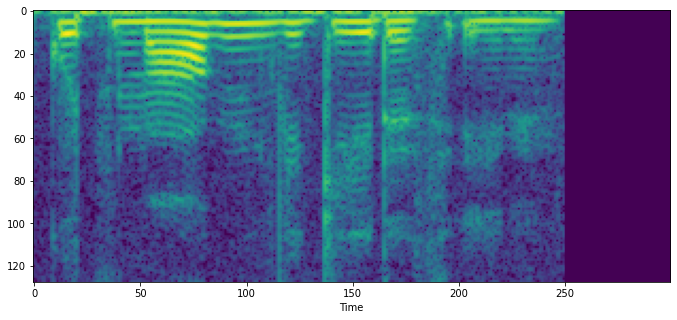

In [27]:
plt.figure(figsize=(15,5))
plt.imshow(now_data[0].view(128,300).cpu().numpy())
plt.xlabel("Time")

In [35]:
sample[0].size()

torch.Size([32, 128, 300])

Text(0.5, 0, 'Time')

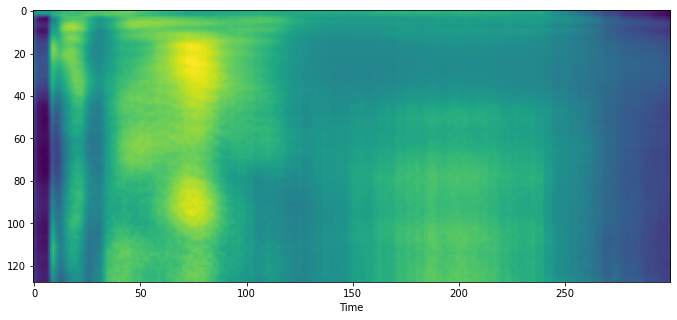

In [28]:
plt.figure(figsize=(15,5))
plt.imshow(sample[0][0].view(128,300).cpu().numpy())
plt.xlabel("Time")

denoising 되는 효과도 있고, 특정 feature가 더 눈에 잘띄는 효과도 있다.

하지만, 뭉개지는 부분도 있다.

# Model Test

- test set
- confusion matrix

In [ ]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [ ]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300_msf_alldata_aug.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




# 기타

In [ ]:
#크기 알아보기
#일반 CNN

m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

In [ ]:
#크기 알아보기
#주파수 영역 CNN

input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


In [ ]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()